# Task 1
1. Find one real-world time-series from any open-source (not less than 150 time steps). For example, it can be some financial or economic indexes, weather measurements for several years, etc.
2. Implement Multi-step LSTM prediction model and ARIMA prediction model for your time series, make the forecast (following the corresponding Jupyter Notebooks). The length of the forecasting period should be not less than 1/5 of time series’ length.
3. Evaluate MAPE and R2 metrics for your model (test set for evaluating the metrics can be, for example, the last 1/5 part of your series).
4. Compare the forecasts of two models on the single plot and choose the most appropriate.

### Data was taken from Kaggle - https://www.kaggle.com/datasets/kanchana1990/egg-sales-of-a-local-shop-for-30-years

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow

from scipy import stats
import statsmodels.api as sm

In [2]:
train_time = pd.read_csv('train_egg_sales.csv', sep=';', index_col=['Date'], parse_dates=['Date'], dayfirst=True)
train_time.index = pd.to_datetime(train_time.index)
train_time.head()

,Egg Sales
Date,
1993-01-01,91
1993-01-02,124
1993-01-03,112
1993-01-04,115
1993-01-05,107


In [3]:
train_time.tail()

,Egg Sales
Date,
2021-12-27,681
2021-12-28,664
2021-12-29,613
2021-12-30,643
2021-12-31,599


In [4]:
train_time.shape

(10592, 1)

So data contains almost 11k rows that satisfies 1 condition
We have data from 1993 to 2021 year for each day, it's better to group sales by month for better visualization

In [5]:
monthly_sales = train_time['Egg Sales'].resample('ME').mean().to_frame()  # group by month

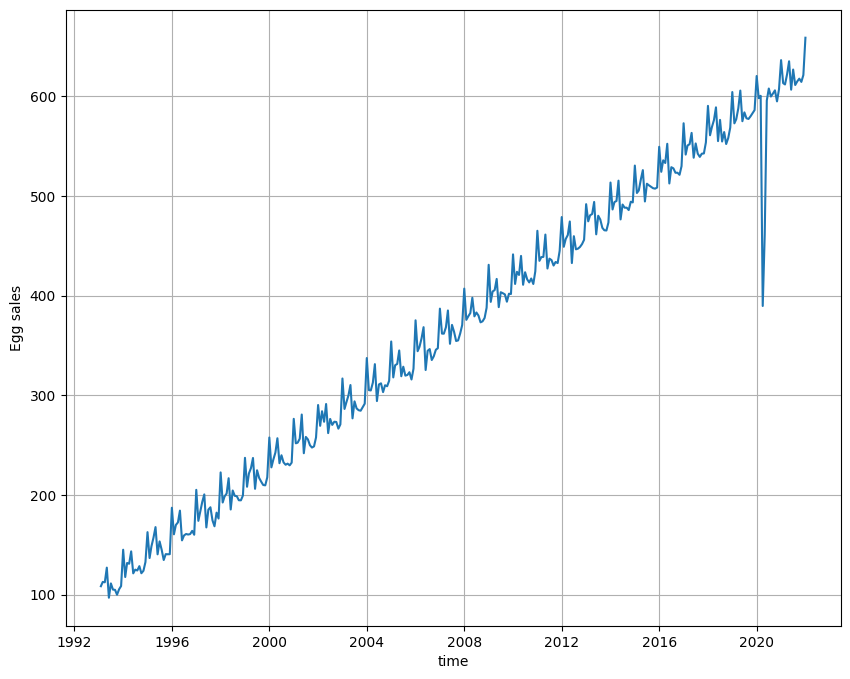

In [6]:
plt.figure(figsize=(10, 8))
plt.plot(monthly_sales)
plt.xlabel('time')
plt.ylabel('Egg sales')
plt.grid()

In [7]:
monthly_sales.loc['2020':'2020-06']

,Egg Sales
Date,
2020-01-31,598.129032
2020-02-29,600.517241
2020-03-31,389.612903
2020-04-30,461.433333
2020-05-31,595.806452
2020-06-30,607.833333


Here in the graph we see upper trend and in the beginning of 2020 there is a rough dump with next returning to initial values for 2020
It might be a good idea to remove outliers in 2020 for better forecasting. Instead of removing we change outliers values for evenly spaced samples, calculated over the interval

In [8]:
print(f"Min value from 2020 - {monthly_sales.loc['2020':].min()} \nMonth with min value - {monthly_sales.loc['2020':].idxmin()}")

Min value from 2020 - Egg Sales    389.612903
dtype: float64 
Month with min value - Egg Sales   2020-03-31
dtype: datetime64[ns]


In [9]:
# monthly_sales.loc['2020-03-31', 'Egg Sales'] = ((monthly_sales.loc['2020-02-29'] + monthly_sales.loc['2020-04-30'])/2)[0]
lin_outliers = np.linspace(monthly_sales.loc['2020-02-29', 'Egg Sales'], monthly_sales.loc['2020-05-31', 'Egg Sales'], 4)
monthly_sales.loc['2020-03-31', 'Egg Sales'] = lin_outliers[1]
monthly_sales.loc['2020-04-30', 'Egg Sales'] = lin_outliers[2]

monthly_sales.loc['2020-03-31']

Egg Sales    598.946978
Name: 2020-03-31 00:00:00, dtype: float64

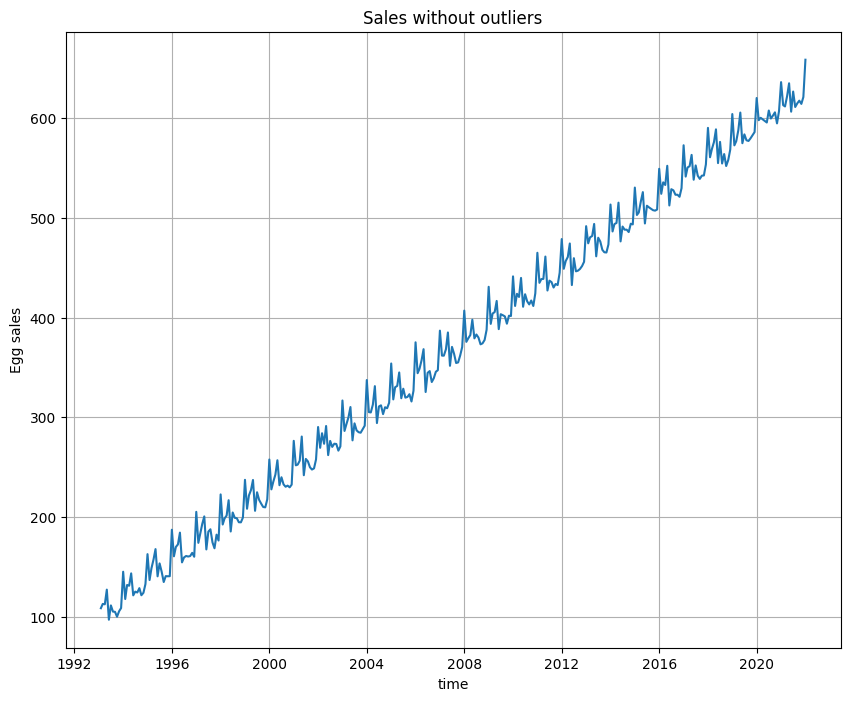

In [10]:
plt.figure(figsize=(10, 8))
plt.plot(monthly_sales)
plt.xlabel('time')
plt.ylabel('Egg sales')
plt.title('Sales without outliers')
plt.grid()

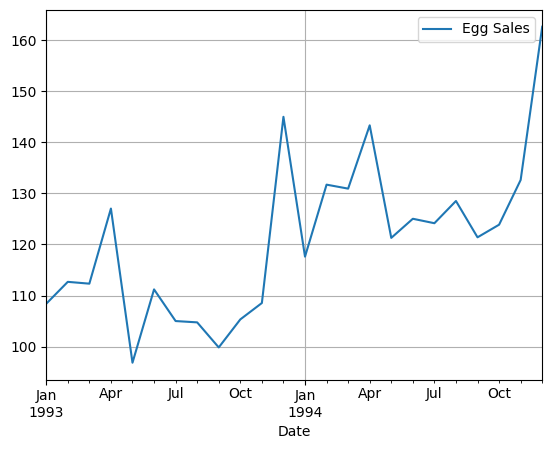

In [11]:
monthly_sales[:24].plot()
plt.grid()

### Divide data to train and test set

In [12]:
monthly_test = monthly_sales.copy()
monthly_test = monthly_test[-round(monthly_sales.shape[0]/5):]
monthly_sales = monthly_sales[:-monthly_test.shape[0]]

Dickey-Fuller test: p=0.943082


<Figure size 1500x1000 with 0 Axes>

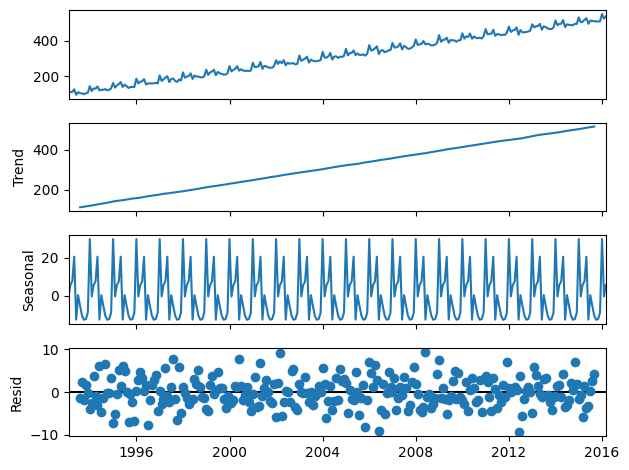

In [13]:
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(monthly_sales).plot()
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(monthly_sales)[1])

P-value is bigger than 0.05, so we cannot reject the H0 - time series is non stationary

Moreover, we see that residuals for the whole time is quite big  

Let's try Box-Cox transformation and look at the result

Best Box-Cox parameter: 0.745274
Dickey-Fuller test: p=0.000001


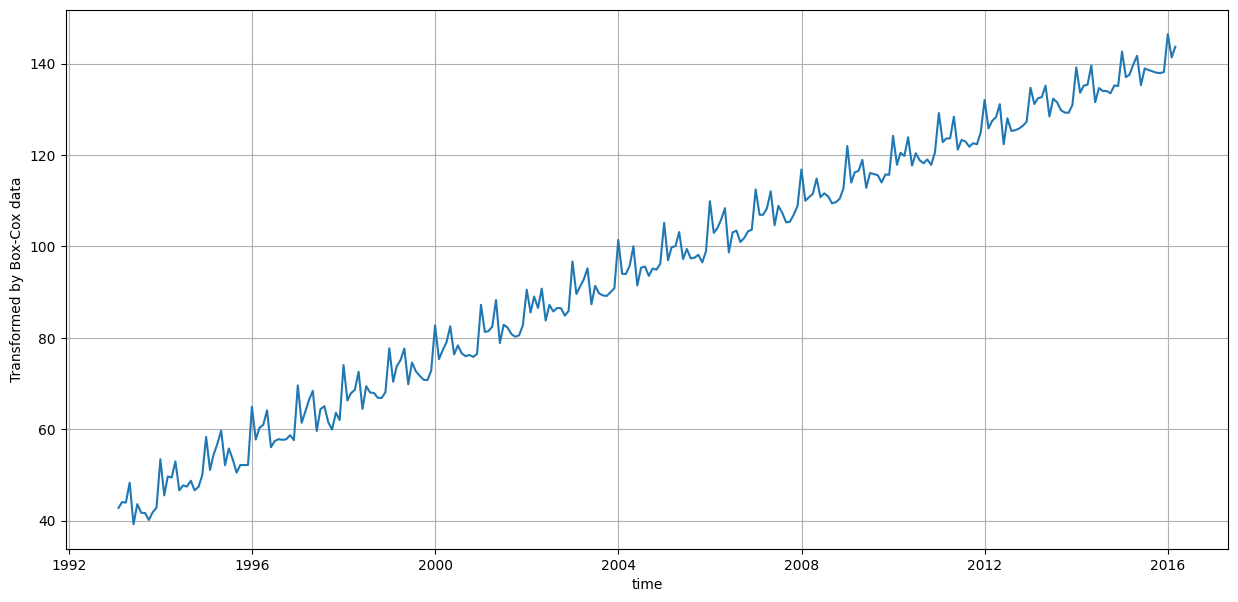

In [14]:
# Box-Cox transformation for dispersion stationarity

monthly_sales['Sales_box'], lmbda = stats.boxcox(monthly_sales['Egg Sales'])
plt.figure(figsize=(15,7))
plt.plot(monthly_sales['Sales_box'])
plt.ylabel('Transformed by Box-Cox data')
plt.xlabel('time')
plt.grid()
print("Best Box-Cox parameter: %f" % lmbda)
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(monthly_sales['Sales_box'])[1])

Dickey-Fuller test: p=0.000001


<Figure size 1500x1000 with 0 Axes>

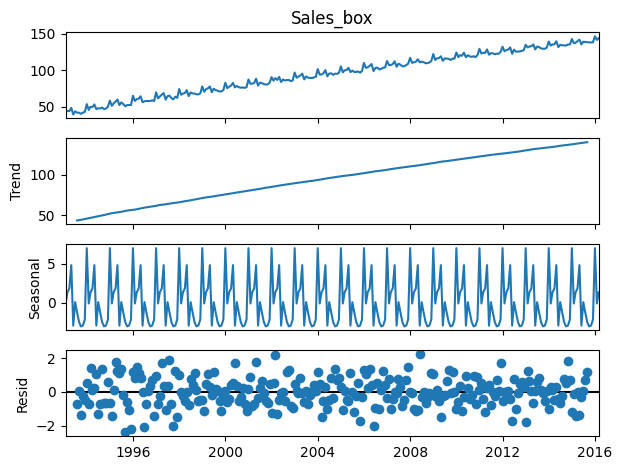

In [15]:
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(monthly_sales['Sales_box']).plot()
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(monthly_sales['Sales_box'])[1])

After applying Box-Cox Transformation Dickey-Fuller test showed p-value lower 0.05, so we can accept H0 - time series is stationary

However, residuals are still have a quite big varience

Let's remove seasonal component from box-cox sales

Dickey-Fuller test: p=0.017301


<Figure size 1500x1000 with 0 Axes>

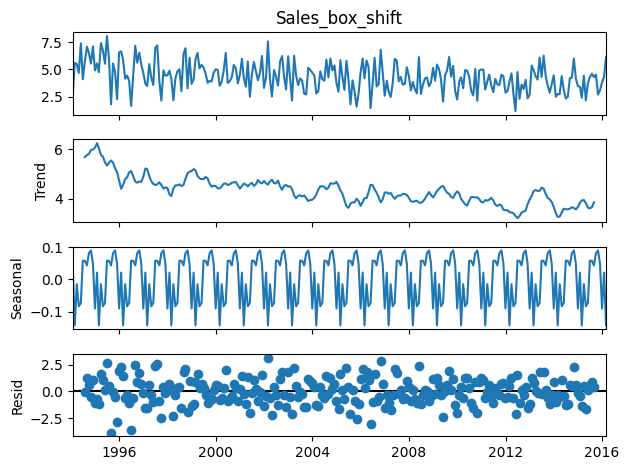

In [16]:
# seasonal difference for 12 months
seas_diff = 12

monthly_sales['Sales_box_shift'] = monthly_sales['Sales_box'] - monthly_sales['Sales_box'].shift(seas_diff)
plt.figure(figsize = (15,10))
sm.tsa.seasonal_decompose(monthly_sales[seas_diff:]['Sales_box_shift']).plot()
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(monthly_sales[seas_diff:]['Sales_box_shift'])[1])

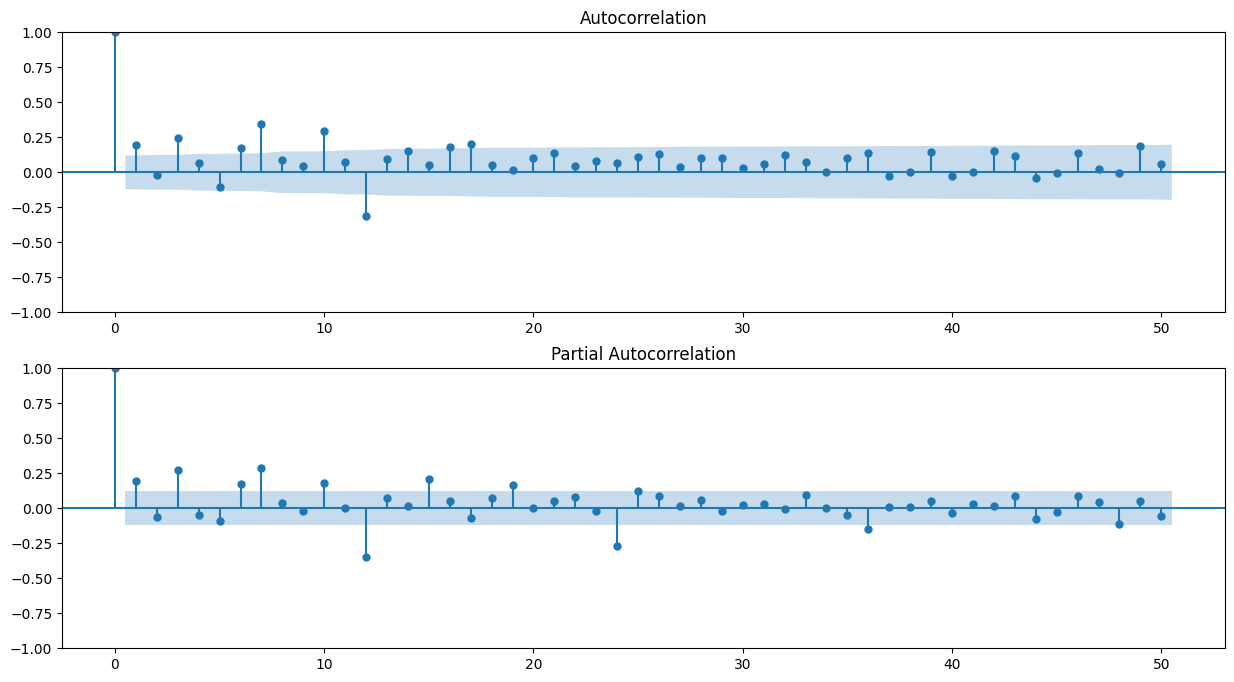

In [17]:
# let's calculate autocorrelation and partial autocorrelation components

plt.figure(figsize=(15,8))

# autocorrelation 
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(monthly_sales[12:]['Sales_box_shift'].values.squeeze(), lags=50, ax=ax)

# partial autocorrelation 
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(monthly_sales[12:]['Sales_box_shift'].values.squeeze(), lags=50, ax=ax)
plt.show()


On the top graph (ACF), you’ll notice that the first few lags (like lag 1) have super high autocorrelation, which means the time series values are really tied to the ones before them. The slow drop in autocorrelation (just like your chart shows) could mean there’s a trend or some seasonality going on.

The bottom graph (PACF) shows that once you get past those first lags, the correlation starts to drop, but there’s one lag (around 12) that still stands out. This might mean there’s some seasonality or a pattern that happens at regular intervals.

## ARIMA implementation

In [18]:
from itertools import product
# parameters for SARIMA model
# better use values < 10
# p and P - show how many autoregressive (AR) terms for non-seasonal (p) and Seasonal (P) component do we want to use
# q and Q - show how many moving average (MA) terms for non-seasonal (q) and Seasonal (Q) component do we want to use
# d - show how many times have we derivated our series 1-step-wise
# D - show how many times have we derivated our series Period-step-wise

ps = range(0, 6)   # 5 
d = 1
qs = range(0, 6)  # 5
Ps = range(0, 2)  # 1
D = 1
Qs = range(0,1)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print ("Number of analysed models:", len(parameters_list))

Number of analysed models: 72


In [19]:
import warnings
results = []
best_aic = float("inf")

# ignore warnings 
warnings.filterwarnings('ignore')

for param in parameters_list:
    
    #try except for the case of wrong parameters
    try:
        model=sm.tsa.statespace.SARIMAX(monthly_sales['Sales_box'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
        
    #print wrong parameters and go on
    # AIC criteria: 
    except ValueError:
        #print('wrong parameters:', param)
        continue
    aic = model.aic
    #print(aic)

    # save best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
        results.append([param, model.aic])
        #print(results)
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())     

def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda*y + 1)/lmbda)

      parameters         aic
10  (4, 3, 1, 0)  778.368562
9   (2, 5, 1, 0)  779.961370
8   (2, 4, 1, 0)  781.566196
7   (2, 3, 1, 0)  788.532436
6   (1, 5, 1, 0)  798.193015


In [20]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters         aic
10  (4, 3, 1, 0)  778.368562
9   (2, 5, 1, 0)  779.961370
8   (2, 4, 1, 0)  781.566196
7   (2, 3, 1, 0)  788.532436
6   (1, 5, 1, 0)  798.193015


In [21]:
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                           Sales_box   No. Observations:                  278
Model:             SARIMAX(4, 1, 3)x(1, 1, [], 12)   Log Likelihood                -380.184
Date:                             Sat, 19 Oct 2024   AIC                            778.369
Time:                                     18:16:41   BIC                            810.586
Sample:                                 01-31-1993   HQIC                           791.313
                                      - 02-29-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0750      0.082      0.918      0.359      -0.085       0.235
ar.L2         -0.9818      

Student test: p=0.129022
Dickey-Fuller test: p=0.0000000000000000000000000


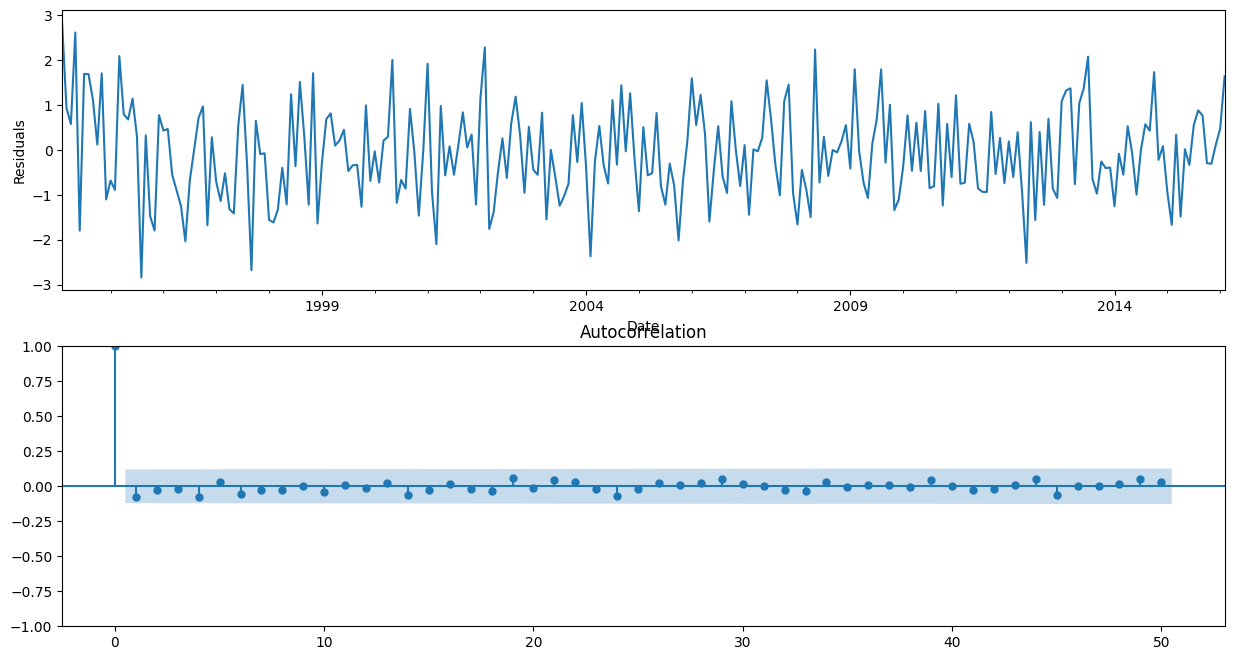

In [22]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[12:].values.squeeze(), lags=50, ax=ax)

print("Student test: p=%f" % stats.ttest_1samp(best_model.resid[12:], 0)[1])
print("Dickey-Fuller test: p=%.25f" % sm.tsa.stattools.adfuller(best_model.resid[12:])[1])

We applied Student test and obtained p-value 0.06 means that residuals do not have a significant deviation from zero — the model copes well.
Also we make Dickey-Fuller test and saw that time series are stationary.

One more good thing is that autocorrelation looks pretty well, no one observations do not higher than confidential interval!

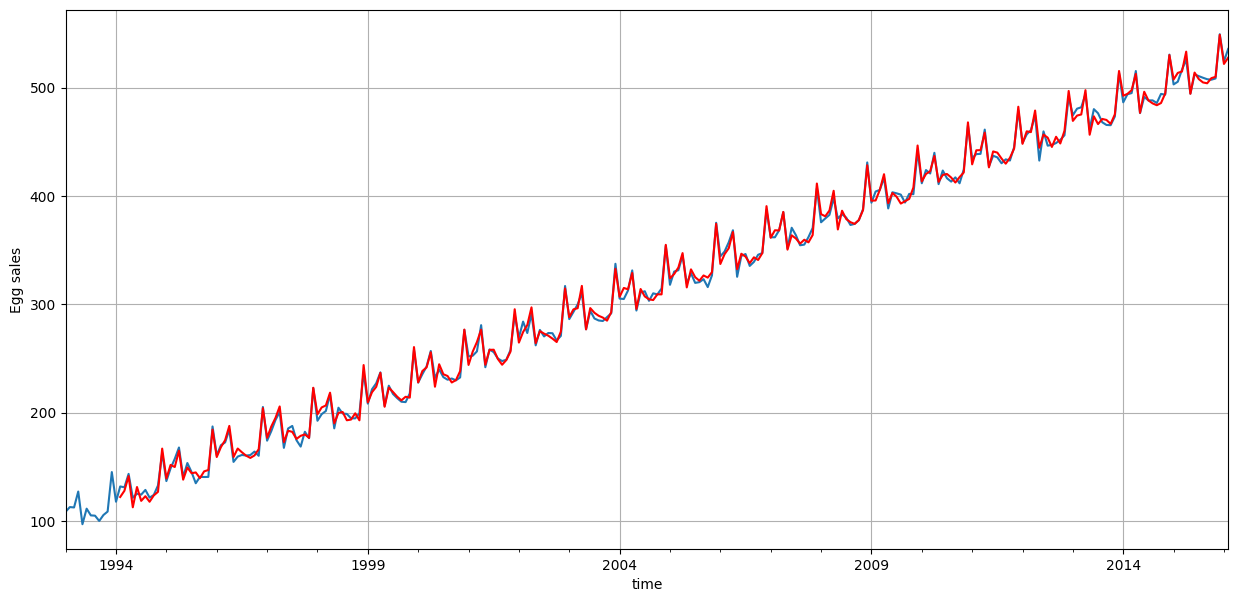

In [23]:
#inverse Box-Cox transformation:

def invboxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbda*y + 1)/lmbda)
    
monthly_sales['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(15,7))
monthly_sales['Egg Sales'].plot()
monthly_sales[13:]['model'].plot(color='r')
plt.ylabel('Egg sales')
plt.xlabel('time')
plt.grid()

As a result we got really good model which understood seasonal component and trend

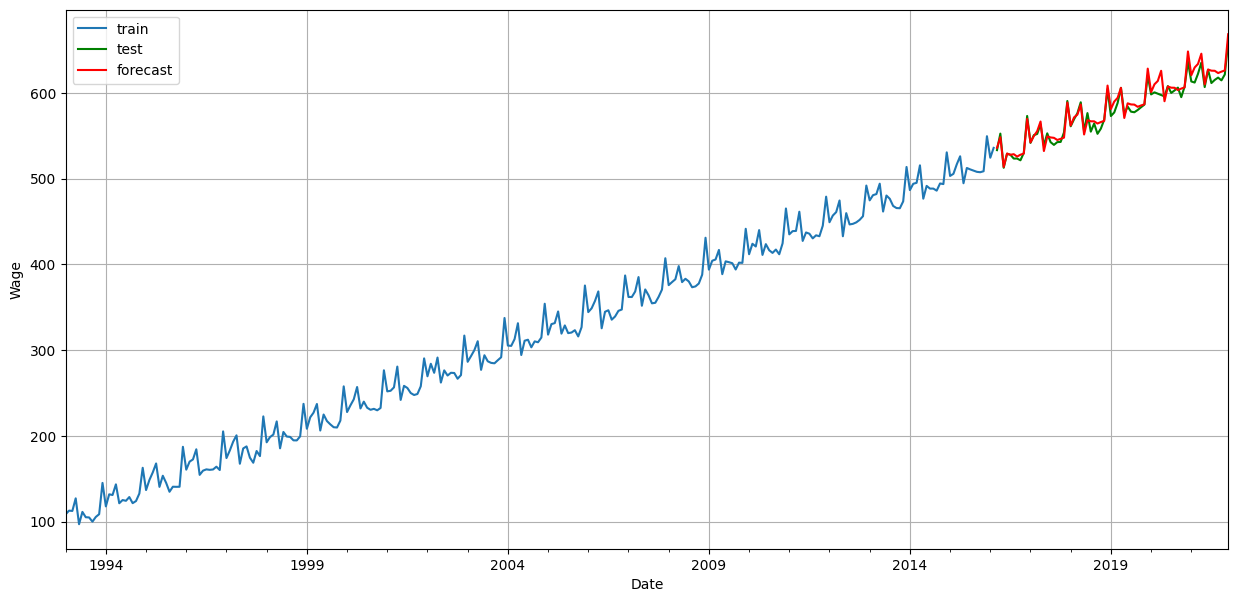

In [24]:
monthly_test['forecast_arima'] = invboxcox(best_model.predict(start=monthly_sales.shape[0], end=monthly_sales.shape[0] + monthly_test.shape[0]), lmbda)

plt.figure(figsize=(15,7))
monthly_sales['Egg Sales'].plot(label = 'train')
monthly_test['Egg Sales'].plot(color='g', label = 'test')
monthly_test['forecast_arima'].plot(color='r', label='forecast')
plt.legend()
plt.ylabel('Wage')
plt.grid()

## LSTM implementation

In [48]:
# RNN - LSTM for time-series forecasting
# partly follows blog https://machinelearningmastery.com/introduction-to-time-series-forecasting-with-python/

from pandas import Series
from pandas import concat
from pandas import read_csv
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Input
from math import sqrt
from matplotlib import pyplot as plt
from numpy import array
 
# trajectory matrix for solving supervized learning task
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if len(data.shape) == 1 else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # входящая последовательность (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # прогнозируемая последовательность (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg


# diffential series interval
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

 
# train / test splitting
def prepare_data(series, n_test, n_lag, n_seq):
    raw_values = series.values
    diff_series = difference(raw_values, 1)
    diff_values = diff_series.values
    diff_values = diff_values.reshape(len(diff_values), 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaled_values = scaler.fit_transform(diff_values)
    scaled_values = scaled_values.reshape(len(scaled_values), 1)
    supervised = series_to_supervised(scaled_values, n_lag, n_seq)
    supervised_values = supervised.values
    train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
    
    print("Supervised shape:", supervised_values.shape)
    print("Train shape before reshaping:", train.shape)

    return scaler, train, test


# fit an LSTM network
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    # reshape training into [samples, timesteps, features]
    X, y = train[:, 0:n_lag], train[:, n_lag:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    y = y.reshape(-1, 1)

    print("X shape:", X.shape)
    print("y shape:", y.shape)

    model = Sequential()
    
    # stateful = True - keep state in memory;
    model.add(Input(batch_shape=(n_batch, X.shape[1], X.shape[2])))
    model.add(LSTM(n_neurons, stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history_loss=[]
    history_val_loss=[]
    for i in range(nb_epoch):
        print(i)
        hist = model.fit(X, y, validation_split=0.15, epochs=1, batch_size=n_batch, verbose=1, shuffle=False)
        history_loss.append(hist.history['loss'])
        history_val_loss.append(hist.history['val_loss'])
    print(model.summary())
    return model,history_loss,history_val_loss
 
# 1 step of forecasting
def forecast_lstm(model, X, n_batch):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, len(X))
    # make forecast
    forecast = model.predict(X, batch_size=n_batch)
    # convert to array
    return [x for x in forecast[0, :]]
 
# Forecasting
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
    forecasts = list()
    for i in range(len(test)):
        X, y = test[i, 0:n_lag], test[i, n_lag:]
        # make forecast
        forecast = forecast_lstm(model, X, n_batch)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

 
# обратная разность
def inverse_difference(last_ob, forecast):
    # invert first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # propagate difference forecast using inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
 
# inverse transformation
def inverse_transform(series, forecasts, scaler, n_test):
    inverted = list()
    for i in range(len(forecasts)):
    # create array from forecast
        forecast = array(forecasts[i])
        forecast = forecast.reshape(1, len(forecast))
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i - 1
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted



In [26]:
# trajectory matrix
series_to_supervised(monthly_sales['Egg Sales'], n_in=12, n_out=1, dropnan=True)

,var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
Date,,,,,,,,,,,,,
1994-01-31,108.387097,112.678571,112.322581,127.033333,96.838710,111.200000,105.000000,104.741935,99.833333,105.322581,108.533333,145.000000,117.612903
1994-02-28,112.678571,112.322581,127.033333,96.838710,111.200000,105.000000,104.741935,99.833333,105.322581,108.533333,145.000000,117.612903,131.714286
1994-03-31,112.322581,127.033333,96.838710,111.200000,105.000000,104.741935,99.833333,105.322581,108.533333,145.000000,117.612903,131.714286,130.935484
1994-04-30,127.033333,96.838710,111.200000,105.000000,104.741935,99.833333,105.322581,108.533333,145.000000,117.612903,131.714286,130.935484,143.333333
1994-05-31,96.838710,111.200000,105.000000,104.741935,99.833333,105.322581,108.533333,145.000000,117.612903,131.714286,130.935484,143.333333,121.290323
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-10-31,494.225806,493.533333,530.516129,503.000000,505.500000,516.612903,525.933333,494.483871,512.300000,510.645161,509.161290,507.800000,507.354839
2015-11-30,493.533333,530.516129,503.000000,505.500000,516.612903,525.933333,494.483871,512.300000,510.645161,509.161290,507.800000,507.354839,508.500000
2015-12-31,530.516129,503.000000,505.500000,516.612903,525.933333,494.483871,512.300000,510.645161,509.161290,507.800000,507.354839,508.500000,549.354839


In [65]:
# hyperparameters initialization and training the model

n_lag = 12
n_seq = 6
n_test = 70
n_epochs = 30
n_batch = 1
n_neurons = 8

scaler, train, test = prepare_data(pd.concat([monthly_sales['Egg Sales'], monthly_test['Egg Sales']]), n_test, n_lag, n_seq)

model,history_loss,history_val_loss = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)

forecasts = inverse_transform(pd.concat([monthly_sales['Egg Sales'], monthly_test['Egg Sales']]), forecasts, scaler, n_test+2)


Supervised shape: (330, 18)
Train shape before reshaping: (260, 18)
X shape: (260, 1, 12)
y shape: (1560, 1)
0
221/221 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1062 - val_loss: 0.1427
1
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0980 - val_loss: 0.1379
2
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0927 - val_loss: 0.1345
3
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0885 - val_loss: 0.1329
4
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0853 - val_loss: 0.1326
5
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0830 - val_loss: 0.1331
6
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0814 - val_loss: 0.1338
7
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0802 - val_loss: 0.1346
8
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0793 - val_loss: 0.1352
9
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0786 - val_loss: 0.1356
10
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0780 - val_loss: 0.1359
11
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/ste

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (1, 8)                 │           672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (1, 1)                 │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,045 (7.99 KB)

 Trainable params: 681 (2.66 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,364 (5.33 KB)

None
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━

[0.0990351215004921] [0.1348659098148346]


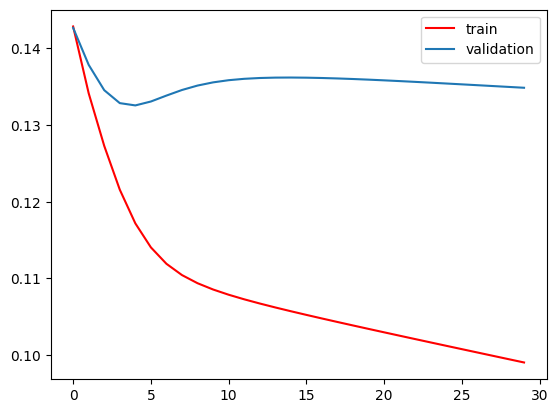

In [66]:
# Loss functions for val and train sets

plt.plot(history_loss, 'r',label='train')
plt.plot(history_val_loss,label='validation')
plt.legend()
print(history_loss[-1],history_val_loss[-1])

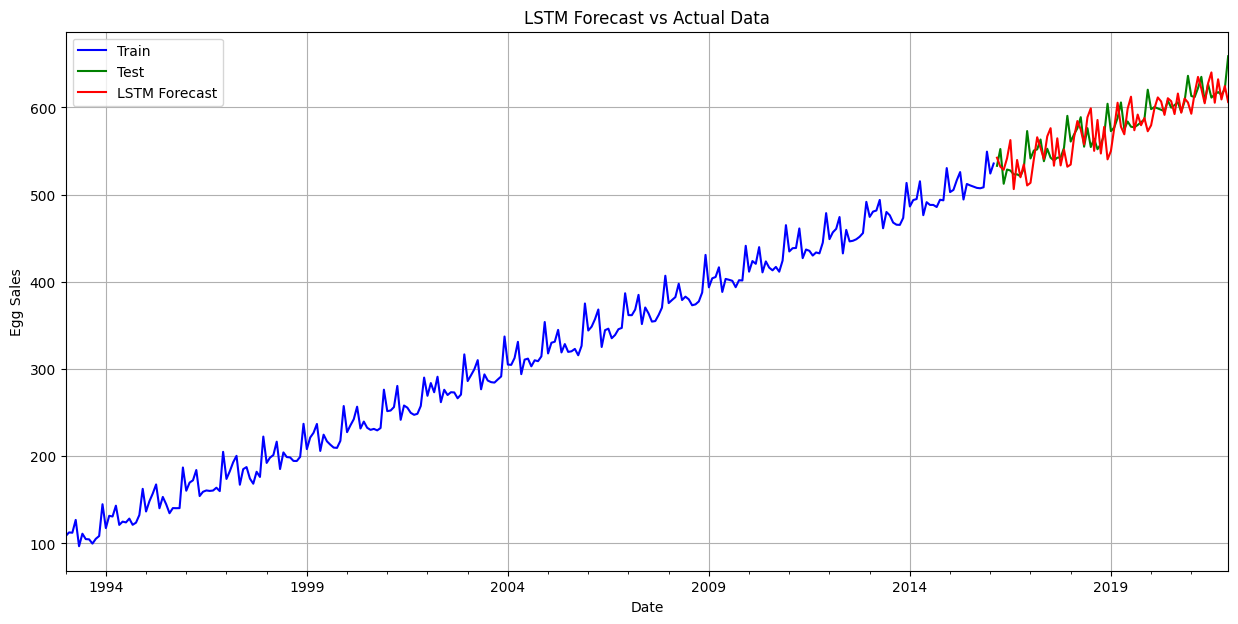

In [67]:
forecasts_flat = [forecast[0] for forecast in forecasts]
monthly_test['forecast_lstm'] = forecasts_flat  # добавляем прогнозы LSTM

# Визуализация
plt.figure(figsize=(15, 7))
monthly_sales['Egg Sales'].plot(label='Train', color='blue')
monthly_test['Egg Sales'].plot(label='Test', color='green')
monthly_test['forecast_lstm'].plot(label='LSTM Forecast', color='red')

plt.title('LSTM Forecast vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Egg Sales')
plt.legend()
plt.grid()
plt.show()

## Compare ARIMA and LSTM

In [68]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

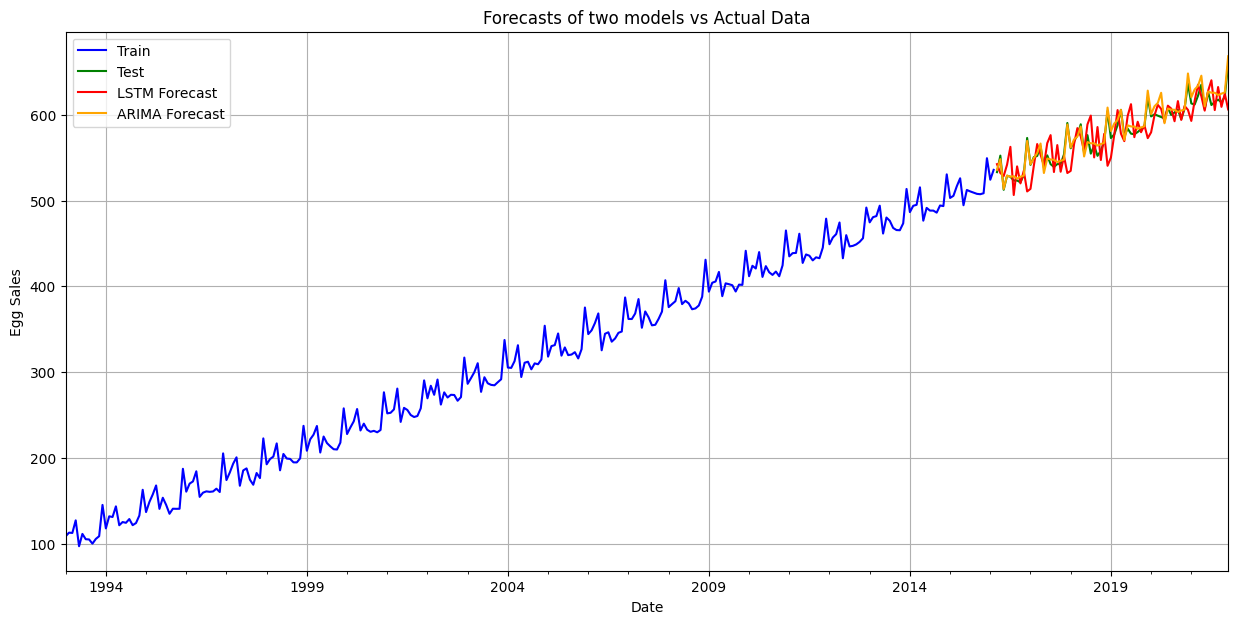

In [69]:
# Визуализация
plt.figure(figsize=(15, 7))
monthly_sales['Egg Sales'].plot(label='Train', color='blue')
monthly_test['Egg Sales'].plot(label='Test', color='green')
monthly_test['forecast_lstm'].plot(label='LSTM Forecast', color='red')
monthly_test['forecast_arima'].plot(label='ARIMA Forecast', color='orange')


plt.title('Forecasts of two models vs Actual Data')
plt.xlabel('Date')
plt.ylabel('Egg Sales')
plt.legend()
plt.grid()

#### It seems to be that ARIMA fitted on the data better than LSTM, forecast of LSTM looks sharpley. Anyway both models clearly understood trend and seasonal component. Let's take a look on the metrics to choose best model

In [71]:
compare_df = pd.DataFrame(
    {
        'R2_score': [round(r2_score(monthly_test['Egg Sales'], monthly_test['forecast_arima']), 2),
                     round(r2_score(monthly_test['Egg Sales'], monthly_test['forecast_lstm']), 2)],
        'MSE': [round(mean_squared_error(monthly_test['Egg Sales'], monthly_test['forecast_arima']), 2),
                round(mean_squared_error(monthly_test['Egg Sales'], monthly_test['forecast_lstm']), 2)],
        'MAPE': [round(mean_absolute_percentage_error(monthly_test['Egg Sales'], monthly_test['forecast_arima']), 2),
                 round(mean_absolute_percentage_error(monthly_test['Egg Sales'], monthly_test['forecast_lstm']), 2)]
    },
    index = ['ARIMA', 'LSTM']
)

compare_df

,R2_score,MSE,MAPE
ARIMA,0.95,56.58,0.01
LSTM,0.55,483.88,0.03


#### So as we assumed earlier ARIMA model predict better than LSTM. Almost 100% of r2_score by ARIMA while LSTM hardly twice much less. Moreover LSTM model has so big mse metric. So the best model is ARIMA for this time series dataset